# Lesson 6: Planning and Stock Report Generation

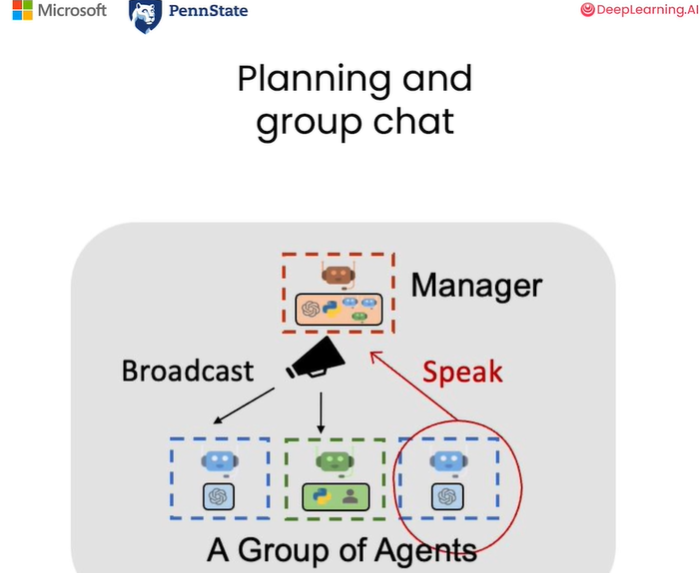

In this last lesson, you will dive deeper into multi-agent group chats
and build a custom group chat that collaborates
to generate a detailed report and stocks performance
over the past month.
Finishing this complex task involves planning,
which is realized by including a planning agent in the group chat.
You will also learn how to customize the speaker's transition into group chat.
Let's dive into the code.
All right.
In this lesson, we're going to learn about
one last agentic design pattern, planning.
And we're going to also learn a new conversation pattern called group chat.

## Setup

In [1]:
llm_config={"model": "gpt-4-turbo"}

## The task!

In [2]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-04-23."

## Build a group chat

This group chat will include these agents:

1. **User_proxy** or **Admin**: to allow the user to comment on the report and ask the writer to refine it.
2. **Planner**: to determine relevant information needed to complete the task.
3. **Engineer**: to write code using the defined plan by the planner.
4. **Executor**: to execute the code written by the engineer.
5. **Writer**: to write the report.

In [3]:
import autogen

In [4]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

In [5]:
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

**What's the difference between the description and system message?**

The system message is an instruction and telling the agent only
and only this agent needs to know. And the description,
I am using that to let other agents know about the role of this agent.
And for example, a manager could decides
when to use this agent based on the description.
So the description is planner.
Given a task, determine what information is needed to complete the task
after each step is done by others, check progress and instruct the
remaining steps.
So less detailed but more manageable
and from a different person's point of view, we can know what this is about.
And we also give it the large language model configuration.
So the planner might suggest some tasks that requires using Python code.
So, you might need some agent that's capable of writing Python code.
So let's define an agent engineer.

In [6]:
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

**Note**: In this lesson, you'll use an alternative method of code execution by providing a dict config. However, you can always use the LocalCommandLineCodeExecutor if you prefer. For more details about code_execution_config, check this: https://microsoft.github.io/autogen/docs/reference/agentchat/conversable_agent/#__init__

In [7]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [8]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## Define the group chat

In [9]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
)

In [10]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)


## Start the group chat!

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

In [11]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------


RateLimitError: Error code: 429 - {'error': {'message': 'exceeded quota for this month'}}

## Add a speaker selection policy

So if we, review this conversation,
we will find that the planner does play the role of suggesting an initial plan.
And after some steps finished,
it will review the progress and just follow the steps.
But not all the steps are followed exactly.
After the first two steps, I think the writer skipped
the third step and started writing the blog post.
This is downside of using language model to design and speak order
S.
But there a few ways you could,
add more control to the conversation.
For example, you. can set constraints about the speaker's order.
I'll show you how to do that.
First, let's repeat the same definition of agents.
So these are the same agents I used
and defined here again.
And I will demonstrate, to add some constraints
in the speaker order.

In [12]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="Write code based on the plan "
    "provided by the planner.",
)

writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer. "
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="After all the info is available, "
    "write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog. ",
)

executor = autogen.ConversableAgent(
    name="Executor",
    description="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [13]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [14]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------


RateLimitError: Error code: 429 - {'error': {'message': 'exceeded quota for this month'}}

**Note**: You might experience slightly different interactions between the agents. The engineer agent may write incorrect code, which the executor agent will report and send back for correction. This process could go through multiple rounds.

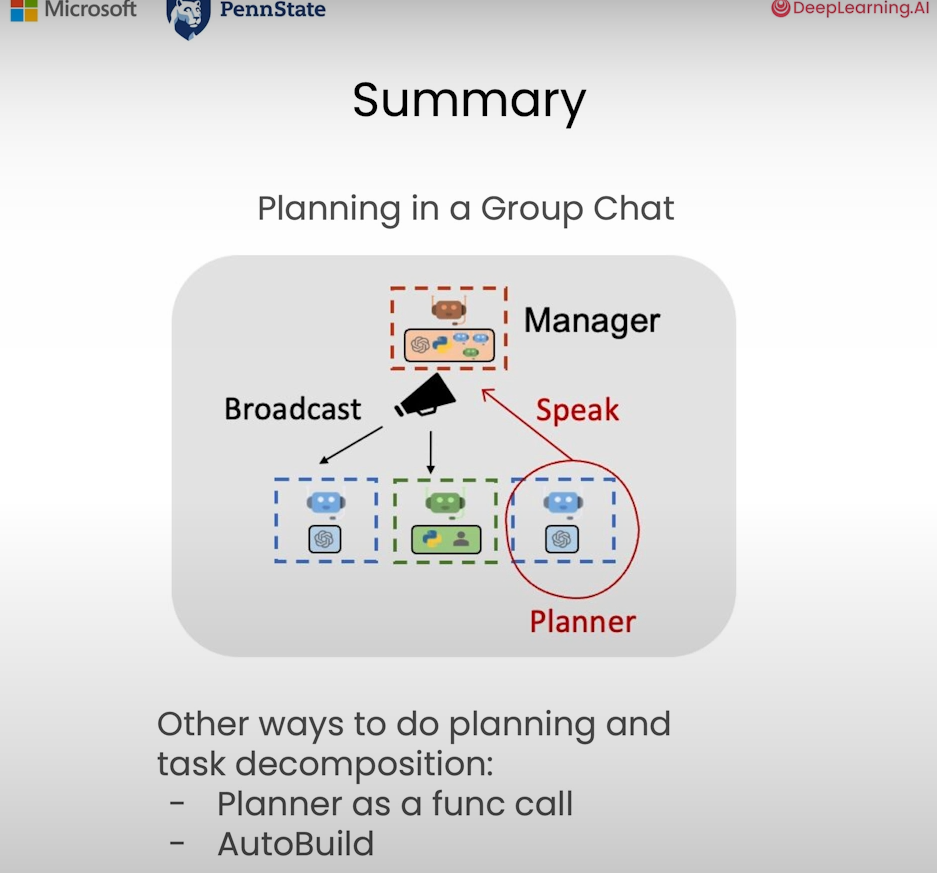

group chat provides a more dynamic way for multiple agents
to solve a task together and without human developers
to design very detailed plan for execution.
You could also add some planner agents, for helping
with making plans and task decomposition. In general,
here can be multiple different ways for doing task
decomposition and planning and where we want to show one example.

We covered, the basic introduction to our AutoGen.
There are many other advanced functionalities in AutoGen
such as teaching agents will improve over time, having multimodality
aving vision capability to understand images.
Using OpenAl assistant as a backend for agents and so on and so forth.
We also have agent-based evaluation tools and benchmarking tools
and other new interesting research.
For example, how can users design agents for particular a task?